## **VISIUM-Based Spatial Transcriptomics Data Analysis of the Human Brain**
---

This notebook implements a step-by-step analysis pipeline for the 10x Genomics Visium dataset ([dataset link](https://www.10xgenomics.com/datasets/gene-and-protein-expression-library-of-human-glioblastoma-cytassist-ffpe-2-standard)) from Human Glioblastoma. Any Visium 2.1.0 dataset  can be loaded and analyzed similarly.


In [1]:
# Step 1: Check if spatialdata is correctly installed and confirm its version
import spatialdata
print(spatialdata.__version__)


/data/u/sameea/miniconda3/envs/spatialenv/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


0.4.0


/data/u/sameea/miniconda3/envs/spatialenv/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
# Step 2: Check if spatialdata-io is correctly installed and confirm its version
!pip show spatialdata-io


DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.


## **Configuration – Set Parameters for Data & Output Paths**

In [3]:
# ====== PARAMETERS / CONFIGURATION ======

# Paths for storing data and outputs
ALL_GENES_CSV = "./content/all_genes.csv"
CANDIDATE_GENE_LIST_PATH = "./content/candidate_genes.csv"
GENE_PLOTS_DIR = "./content/gene_plots/"
SCATTER_PLOT_PATH = "./content/scatter_plot.png"
JOINT_EXPR_CSV = "./content/joint_expression_scores.csv"
JOINT_EXPR_PLOT_PATH = "./content/joint_expression_heatmap.png"


# Exporting Gene Expression Matrix
EXPR_MATRIX_CSV = "./content/gene_expression_matrix_VISIUM.csv"

# Exporting spatial information of cells/spots
SPATIAL_COORDS_CSV = "./content/visium_spatial_coordinates_VISIUM.csv"

# Other parameters
SCATTER_POINT_SIZE = 7
SCATTER_ALPHA = 0.8

# Gene for single gene expression visualization example
EXAMPLE_GENE = "B3GALT6"
EXAMPLE_GENE_HEATMAP = "./content/gene_plots/B3GALT6_heatmap.png"
# Ranked gene list based on expression variability
RANKED_GENE_LIST_PATH = "./content/ranked_genes_visium.csv"
TOP_VARIABLE_GENE_RANK = 10  # Change to the N-th gene you want to visualize

## **Importing Necessary Libraries**

In [4]:
import zipfile
import os
from spatialdata import SpatialData
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# 📁Data Loading

---

We now download and extract the 10x Genomics Visium dataset. This dataset captures molecular and spatial information from human brain region.

In [5]:
# Source: https://github.com/giovp/spatialdata-sandbox/blob/main/utils.py

import os
import subprocess
import urllib.request
import zipfile
from typing import Callable, Any
from spatialdata import SpatialData
from pathlib import Path
import shutil

from tqdm import tqdm


class TqdmDownload(tqdm):
    def __init__(self, *args, **kwargs):
        kwargs = dict(kwargs)
        kwargs.update({"unit": "B", "unit_scale": True, "unit_divisor": 1024})
        super().__init__(*args, **kwargs)

    def update_to(self, nblocks=1, blocksize=1, total=-1):
        self.total = total
        self.update(nblocks * blocksize - self.n)


def is_aria2c_installed():
    rc = subprocess.call(["which", "aria2c"])
    if rc == 0:
        return True
    else:
        return False


def download(url, outfile, desc):
    # aria2c (maybe) is faster than urllib
    if not is_aria2c_installed() or True:
        subprocess.check_call(
            [
                "curl",
                "-o",
                outfile,
                url,
            ]
        )
    else:
        subprocess.check_call(
            [
                "aria2c",
                "--allow-overwrite",
                "-x",
                "4",
                "--dir",
                os.path.dirname(outfile),
                "-o",
                os.path.basename(outfile),
                url,
            ]
        )


def unzip(file, outdir=None, files=None, rm=True):
    if outdir is None:
        outdir = os.getcwd()
    else:
        os.makedirs(outdir, exist_ok=True)
    zfile = zipfile.ZipFile(file)
    if files is not None:
        for f in files:
            zfile.extract(f, outdir)
    else:
        zfile.extractall(outdir)
    zfile.close()
    if rm:
        os.unlink(file)

In [6]:
# Source: https://github.com/giovp/spatialdata-sandbox/blob/main/visium_2.1.0_2_io/download.py

import os
import subprocess
from pathlib import Path
import sys

# Add current directory to sys.path
sys.path.insert(1, os.getcwd())


# Download URLs from 10x Genomics
urls = [
    "https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_tissue_image.tif",
    "https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_image.tif",
    "https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_alignment_file.json",
    "https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_molecule_info.h5",
    "https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_filtered_feature_bc_matrix.h5",
    "https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz",
]

# Create data directory
os.makedirs("data", exist_ok=True)

# Download files
for url in urls:
    print("Downloading:", url)
    name = Path(url).name
    download(url, os.path.join("data", name), name)

# Extract spatial data
subprocess.run("tar -xzf data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz -C data", shell=True, check=True)
subprocess.run("rm data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz", shell=True, check=True)


Downloading: https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_tissue_image.tif


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 2645M    0  2729    0     0   4451      0   7d 05h --:--:--   7d 05h  4444

  1 2645M    1 42.5M    0     0  32.3M      0  0:01:21  0:00:01  0:01:20 32.2M

  5 2645M    5  135M    0     0  58.7M      0  0:00:45  0:00:02  0:00:43 58.6M

  8 2645M    8  223M    0     0  67.3M      0  0:00:39  0:00:03  0:00:36 67.3M

 11 2645M   11  316M    0     0  73.3M      0  0:00:36  0:00:04  0:00:32 73.3M

 16 2645M   16  428M    0     0  80.5M      0  0:00:32  0:00:05  0:00:27 91.0M

 20 2645M   20  540M    0     0  85.5M      0  0:00:30  0:00:06  0:00:24 99.5M

 24 2645M   24  651M    0     0  89.0M      0  0:00:29  0:00:07  0:00:22  103M

 28 2645M   28  758M    0     0  91.2M      0  0:00:28  0:00:08  0:00:20  107M

 32 2645M   32  859M    0     0  92.1M      0  0:00:28  0:00:09  0:00:19  108M

 36 2645M   36  966M    0     0  93.6M      0  0:00:28  0:00:10  0:00:18  107M

 40 2645M   40 1074M    0     0  94.9M      0  0:00:27  0:00:11  0:00:16  106M

 44 2645M   44 1185M    0     0  96.2M      0  0:00:27  0:00:12  0:00:15  106M

 48 2645M   48 1274M    0     0  95.6M      0  0:00:27  0:00:13  0:00:14  103M

 51 2645M   51 1367M    0     0  95.5M      0  0:00:27  0:00:14  0:00:13  101M

 55 2645M   55 1479M    0     0  96.6M      0  0:00:27  0:00:15  0:00:12  102M

 59 2645M   59 1576M    0     0  96.6M      0  0:00:27  0:00:16  0:00:11  100M

 63 2645M   63 1670M    0     0  96.4M      0  0:00:27  0:00:17  0:00:10 96.9M

 67 2645M   67 1782M    0     0  97.3M      0  0:00:27  0:00:18  0:00:09  101M

 71 2645M   71 1894M    0     0  98.0M      0  0:00:26  0:00:19  0:00:07  105M

 75 2645M   75 2005M    0     0  98.7M      0  0:00:26  0:00:20  0:00:06  105M

 80 2645M   80 2117M    0     0  99.3M      0  0:00:26  0:00:21  0:00:05  108M

 84 2645M   84 2229M    0     0  99.9M      0  0:00:26  0:00:22  0:00:04  111M

 88 2645M   88 2341M    0     0   100M      0  0:00:26  0:00:23  0:00:03  111M

 92 2645M   92 2453M    0     0   100M      0  0:00:26  0:00:24  0:00:02  111M

 96 2645M   96 2565M    0     0   101M      0  0:00:26  0:00:25  0:00:01  111M

100 2645M  100 2645M    0     0   100M      0  0:00:26  0:00:26 --:--:--  107M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Downloading: https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_image.tif


100 22.3M  100 22.3M    0     0  35.4M      0 --:--:-- --:--:-- --:--:-- 35.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Downloading: https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_alignment_file.json


  0 1478k    0  2729    0     0   4166      0  0:06:03 --:--:--  0:06:03  4160

100 1478k  100 1478k    0     0  1584k      0 --:--:-- --:--:-- --:--:-- 1584k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Downloading: https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_molecule_info.h5


  0 1640M    0  102k    0     0   243k      0  1:55:10 --:--:--  1:55:10  242k

  6 1640M    6  109M    0     0  77.0M      0  0:00:21  0:00:01  0:00:20 77.0M

 12 1640M   12  210M    0     0  87.2M      0  0:00:18  0:00:02  0:00:16 87.1M

 19 1640M   19  320M    0     0  93.8M      0  0:00:17  0:00:03  0:00:14 93.8M

 26 1640M   26  432M    0     0  97.9M      0  0:00:16  0:00:04  0:00:12 97.8M

 32 1640M   32  531M    0     0  96.3M      0  0:00:17  0:00:05  0:00:12  104M

 38 1640M   38  623M    0     0  97.1M      0  0:00:16  0:00:06  0:00:10  102M

 41 1640M   41  676M    0     0  91.2M      0  0:00:17  0:00:07  0:00:10 93.1M

 47 1640M   47  779M    0     0  92.5M      0  0:00:17  0:00:08  0:00:09 91.7M

 53 1640M   53  883M    0     0  93.8M      0  0:00:17  0:00:09  0:00:08 90.2M

 60 1640M   60  995M    0     0  95.5M      0  0:00:17  0:00:10  0:00:07 94.7M

 66 1640M   66 1082M    0     0  94.8M      0  0:00:17  0:00:11  0:00:06 91.8M

 72 1640M   72 1191M    0     0  95.9M      0  0:00:17  0:00:12  0:00:05  103M

 79 1640M   79 1303M    0     0  97.1M      0  0:00:16  0:00:13  0:00:03  104M

 86 1640M   86 1411M    0     0  97.8M      0  0:00:16  0:00:14  0:00:02  105M

 92 1640M   92 1522M    0     0  98.7M      0  0:00:16  0:00:15  0:00:01  105M

100 1640M  100 1640M    0     0  99.1M      0  0:00:16  0:00:16 --:--:--  108M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Downloading: https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_filtered_feature_bc_matrix.h5


  0 41.7M    0  338k    0     0   398k      0  0:01:47 --:--:--  0:01:47  398k

 69 41.7M   69 29.0M    0     0  15.7M      0  0:00:02  0:00:01  0:00:01 15.7M

100 41.7M  100 41.7M    0     0  18.5M      0  0:00:02  0:00:02 --:--:-- 18.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Downloading: https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz


  0 32.9M    0  4098    0     0   7126      0  1:20:49 --:--:--  1:20:49  7114

100 32.9M  100 32.9M    0     0  31.3M      0  0:00:01  0:00:01 --:--:-- 31.3M


CompletedProcess(args='rm data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz', returncode=0)

In [7]:
# Source: https://github.com/giovp/spatialdata-sandbox/blob/main/visium_2.1.0_2_io/to_zarr.py
# ----------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------
# ---------------------------------- spatialdata-sandbox ---------------------------------------------------
# ----------------------------------------------------------------------------------------------------------

from spatialdata_io import visium
import spatialdata as sd
##
from pathlib import Path
import shutil

##
path = Path().resolve()
# luca's workaround for pycharm
path_read = path / "data"
path_write = path / "data.zarr"
##
sdata = visium(path_read, fullres_image_file="CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_tissue_image.tif")
##
if path_write.exists():
    shutil.rmtree(path_write)
sdata.write(path_write)
print("done")
##
print(f'view with "python -m napari_spatialdata view data.zarr"')
sdata = sd.SpatialData.read(path_write)
print(sdata)
print("read")


/data/u/sameea/miniconda3/envs/spatialenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


INFO     reading                                                                                                   
         /data/u/sameea/spatialomics-toolkit/Visium/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_filte
         red_feature_bc_matrix.h5                                                                                  


/data/u/sameea/miniconda3/envs/spatialenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/data/u/sameea/miniconda3/envs/spatialenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/u/sameea/miniconda3/envs/spatialenv/lib/python3.10/site-packages/spatialdata/models/models.py:1144: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


INFO     The Zarr backing store has been changed from None the new file path:                                      
         /data/u/sameea/spatialomics-toolkit/Visium/data.zarr                                                      


version mismatch: detected: RasterFormatV02, requested: FormatV04


/data/u/sameea/miniconda3/envs/spatialenv/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04


version mismatch: detected: RasterFormatV02, requested: FormatV04


done
view with "python -m napari_spatialdata view data.zarr"


/data/u/sameea/miniconda3/envs/spatialenv/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /data/u/sameea/spatialomics-toolkit/Visium/data.zarr
├── Images
│     ├── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_full_image': DataTree[cyx] (2, 28202, 24591), (2, 14101, 12295), (2, 7050, 6147), (2, 3525, 3073), (2, 1762, 1536)
│     ├── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image': DataArray[cyx] (3, 2000, 1744)
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image': DataArray[cyx] (3, 600, 523)
├── Shapes
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma': GeoDataFrame shape: (5756, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (5756, 18085)
with coordinate systems:
    ▸ 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_full_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_im

In [8]:
# As you know the .zarr folder name exactly (e.g., visium.zarr or data.zarr), define the path
zarr_path = './data.zarr'  # adjust if folder name is different
print("Zarr folder path:", zarr_path)


Zarr folder path: ./data.zarr


In [9]:
from spatialdata import SpatialData

# Read the SpatialData object
sdata = SpatialData.read(zarr_path)
print(sdata)


version mismatch: detected: RasterFormatV02, requested: FormatV04


/data/u/sameea/miniconda3/envs/spatialenv/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04


version mismatch: detected: RasterFormatV02, requested: FormatV04


/data/u/sameea/miniconda3/envs/spatialenv/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /data/u/sameea/spatialomics-toolkit/Visium/data.zarr
├── Images
│     ├── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_full_image': DataTree[cyx] (2, 28202, 24591), (2, 14101, 12295), (2, 7050, 6147), (2, 3525, 3073), (2, 1762, 1536)
│     ├── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image': DataArray[cyx] (3, 2000, 1744)
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image': DataArray[cyx] (3, 600, 523)
├── Shapes
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma': GeoDataFrame shape: (5756, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (5756, 18085)
with coordinate systems:
    ▸ 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_full_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_im

# **Dataset Structure Exploration**
---

After loading the dataset, we inspect the structure of the `SpatialData` object. This helps us understand the types of spatial and tabular information available, including images, labels, shapes, and cell-level metadata stored in the `AnnData` table.


In [10]:
# View available image keys in the spatial dataset
print("Images:", list(sdata.images.keys()))

# View available label (segmentation or annotation) keys
print("Labels:", list(sdata.labels.keys()))

# View geometric shape annotations if any are present
print("Shapes:", list(sdata.shapes.keys()))

# Confirm the type of the underlying table storing observations
print("Table object type:", type(sdata.table))

# Check the size of the AnnData object (cells × features)
print("AnnData shape:", sdata.table.shape)

# Preview the first few rows of the observations (cell metadata)
print("Table Preview:")
print(sdata.table.obs.head())

Images: ['CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_full_image', 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image', 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image']
Labels: []
Shapes: ['CytAssist_FFPE_Protein_Expression_Human_Glioblastoma']
Table object type: <class 'anndata._core.anndata.AnnData'>
AnnData shape: (5756, 18085)
Table Preview:
                    in_tissue  array_row  array_col  spot_id  \
AACAATGGAACCACAT-1          1         54         32        0   
AACAATGTGCTCCGAG-1          1         98        158        1   
AACACCAGCCTACTCG-1          1         31         39        2   
AACACCATTCGCATAC-1          1         53        139        3   
AACACCGAATGTCTCA-1          1         34        176        4   

                                                               region  
AACAATGGAACCACAT-1  CytAssist_FFPE_Protein_Expression_Human_Gliobl...  
AACAATGTGCTCCGAG-1  CytAssist_FFPE_Protein_Expression_Human_Gliobl...  
AACACCA

/tmp/ipykernel_52535/3281537800.py:11: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  print("Table object type:", type(sdata.table))
/tmp/ipykernel_52535/3281537800.py:14: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  print("AnnData shape:", sdata.table.shape)
/tmp/ipykernel_52535/3281537800.py:18: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  print(sdata.table.obs.head())


In [11]:
# Extract expression matrix
X = sdata.table.X
if hasattr(X, "toarray"):  # Convert sparse to dense
    X = X.toarray()

# Create DataFrame
expression_df = pd.DataFrame(X, index=sdata.table.obs_names, columns=sdata.table.var_names)

# Save to CSV
expression_df.to_csv(EXPR_MATRIX_CSV)
print(f"Gene expression matrix saved to {EXPR_MATRIX_CSV}")


/tmp/ipykernel_52535/2387418767.py:2: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  X = sdata.table.X
/tmp/ipykernel_52535/2387418767.py:7: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  expression_df = pd.DataFrame(X, index=sdata.table.obs_names, columns=sdata.table.var_names)


Gene expression matrix saved to ./content/gene_expression_matrix_VISIUM.csv


In [12]:
# Extract 2D coordinates
coords = sdata.table.obsm["spatial"]

# Create DataFrame with spot/cell IDs and coordinates
spatial_df = pd.DataFrame({
    "cell_id": sdata.table.obs_names,
    "x": coords[:, 0],
    "y": coords[:, 1]
})

# Save to CSV
SPATIAL_COORDS_CSV = "visium_spatial_coordinates.csv"
spatial_df.to_csv(SPATIAL_COORDS_CSV, index=False)
print(f"Spatial coordinates saved to {SPATIAL_COORDS_CSV}")


Spatial coordinates saved to visium_spatial_coordinates.csv


/tmp/ipykernel_52535/535106236.py:2: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  coords = sdata.table.obsm["spatial"]
/tmp/ipykernel_52535/535106236.py:6: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  "cell_id": sdata.table.obs_names,


# **Essential Dataset Tools**
---

In the following sections, we extract and save useful metadata from the dataset for external inspection or visualization or even downstream analysis.





## **Save All Gene Names to CSV**  

---

  Extract all gene names from the spatial transcriptomics dataset and save them in a CSV file. This allows for easy access when performing gene filtering, ranking, or downstream selection.

In [13]:
import pandas as pd

# Save gene names from the AnnData inside SpatialData
gene_names = sdata.table.var_names.to_list()
gene_df = pd.DataFrame({"gene": gene_names})
gene_df.to_csv(ALL_GENES_CSV, index=False)

print(f"Saved {len(gene_names)} gene names to {ALL_GENES_CSV}")

Saved 18085 gene names to ./content/all_genes.csv


/tmp/ipykernel_52535/29283005.py:4: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  gene_names = sdata.table.var_names.to_list()


## **Checking Spatial Geometry and Coordinate Dimensionality**

---

This code verifies the spatial data’s geometric structure prints the coordinate dimensionality to confirm whether the dataset represents 2D or 3D spatial data.

This check is important for choosing appropriate visualization and analysis methods based on spatial complexity.

In [14]:
print(sdata.shapes.keys())

dict_keys(['CytAssist_FFPE_Protein_Expression_Human_Glioblastoma'])


In [15]:
# Automatically select the first available shape layer
shape_layer_name = list(sdata.shapes.keys())[0]
print(shape_layer_name)

CytAssist_FFPE_Protein_Expression_Human_Glioblastoma


In [16]:
# Checking if dataset is 2D or 3D
geometry = sdata.shapes[shape_layer_name]['geometry']
assert all(geometry.geom_type == 'Point'), "Non-point geometries found!"
coords_dim = geometry.apply(lambda g: len(g.coords[0])).unique()
print(f"Coordinate dimensionality: {coords_dim}")


Coordinate dimensionality: [2]


## **Visualizing Spatial Positions of Cells**
---
This subsection plots all detected cells (spots) in their spatial coordinates using a scatter plot.  
Each dot represents a single cell’s position within the tissue section.

/tmp/ipykernel_52535/334913332.py:4: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  coords = sdata.table.obsm["spatial"]  # shape: (n_spots, 2), columns = x, y


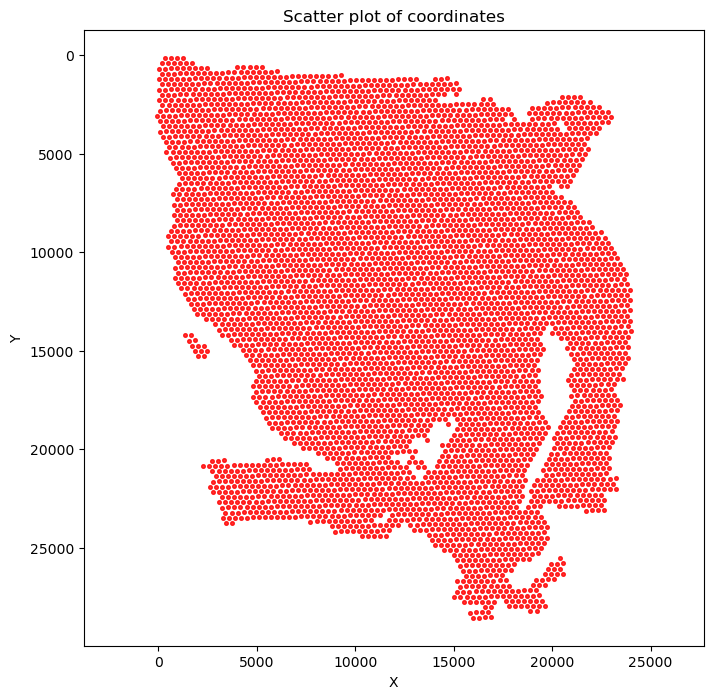

In [17]:
import matplotlib.pyplot as plt

# Step 1: Extract the coordinates
coords = sdata.table.obsm["spatial"]  # shape: (n_spots, 2), columns = x, y

# Step 2: Plot the coordinates
plt.figure(figsize=(8, 8))
plt.scatter(coords[:, 0], coords[:, 1], s=SCATTER_POINT_SIZE, alpha=SCATTER_ALPHA, c='red')
plt.title("Scatter plot of coordinates")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().invert_yaxis()  # Optional: flip to match image orientation
plt.grid(False)
plt.axis("equal")
plt.savefig(SCATTER_PLOT_PATH, dpi=300, bbox_inches='tight')
plt.show()


## **Visualizing Single Gene Expression Heatmap**

This section defines a function to visualize the spatial expression pattern of any selected gene across the tissue section. An example is provided for the gene **“Asic4”**, and the output plot is saved in the folder `/content/gene_plots/`.

In [18]:
def plot_gene_expression_heatmap(sdata, gene_name, output_path=None):
    # Get the AnnData table (assuming there's only one, e.g., 'table')
    table = list(sdata.tables.values())[0]

    # Check if gene exists
    if gene_name not in table.var_names:
        print(f"Gene '{gene_name}' not found in dataset.")
        return

    # Get expression values
    gene_index = table.var_names.get_loc(gene_name)
    X = table.X
    if hasattr(X, "toarray"):  # If sparse, convert to dense
        expression_values = X[:, gene_index].toarray().flatten()
    else:  # Already dense
        expression_values = X[:, gene_index].flatten()

    # Get cell coordinates
    geometry = sdata.shapes[shape_layer_name]['geometry']
    x = geometry.x
    y = geometry.y

    # Plot
    plt.figure(figsize=(7, 6))
    scatter = plt.scatter(x, y, c=expression_values, cmap='viridis', s=SCATTER_POINT_SIZE, alpha=SCATTER_ALPHA)
    plt.colorbar(scatter, label=f"{gene_name} expression")
    plt.title(f"Expression Heatmap: {gene_name}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


In [19]:
# Create directory if it doesn't exist
os.makedirs(GENE_PLOTS_DIR, exist_ok=True)


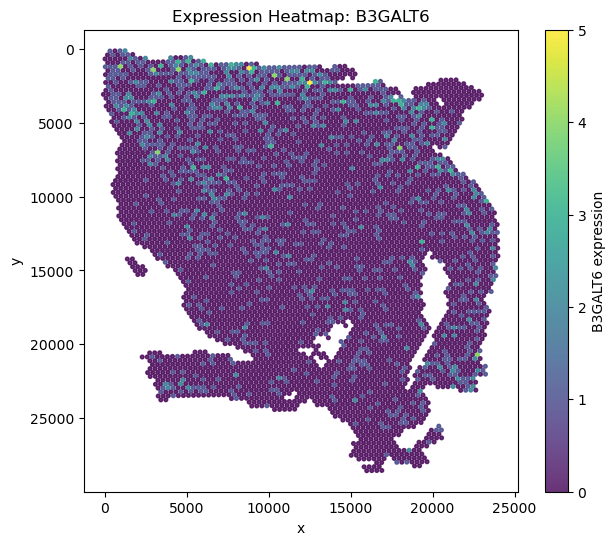

In [20]:
plot_gene_expression_heatmap(sdata, EXAMPLE_GENE, EXAMPLE_GENE_HEATMAP)


In [21]:
def rank_genes_using_scanpy(sdata, output_csv_path):
    adata = sdata.table.copy()

    if hasattr(adata.X, "toarray"):
        adata.X = adata.X.toarray()
    adata.X = adata.X.astype(np.float32)
    adata.X[np.isnan(adata.X)] = 0
    adata.X[np.isinf(adata.X)] = 0

    sc.pp.highly_variable_genes(
        adata,
        flavor="cell_ranger",
        n_top_genes=adata.shape[1],
        inplace=True
    )

    var_cols = adata.var.columns
    if 'dispersions' in var_cols:
        dispersion_col = 'dispersions'
    elif 'dispersions_norm' in var_cols:
        dispersion_col = 'dispersions_norm'
    else:
        raise ValueError(f"No dispersion column found. Available: {var_cols}")

    ranked_df = adata.var.reset_index()
    ranked_df = ranked_df[['index', 'means', dispersion_col]]
    ranked_df.columns = ['gene', 'mean', 'dispersion']
    ranked_df = ranked_df.sort_values(by='dispersion', ascending=False)
    ranked_df.to_csv(output_csv_path, index=False)
    print(f"Saved ranked gene list to {output_csv_path}")
    return ranked_df


In [22]:
def plot_top_variable_gene(sdata, ranked_df, rank=1, output_path=None):
    """
    Plot expression of the N-th most variable gene (1-based rank).

    Parameters:
    - sdata: SpatialData object
    - ranked_df: DataFrame containing ranked gene info
    - rank: 1-based index of the gene to plot (e.g., rank=1 for top gene)
    - output_path: Optional path to save the plot
    """
    if rank < 1 or rank > len(ranked_df):
        print(f"Invalid rank: {rank}. Must be between 1 and {len(ranked_df)}.")
        return

    gene_name = ranked_df.iloc[rank - 1]['gene']
    table = sdata.table

    if gene_name not in table.var_names:
        print(f"Gene '{gene_name}' not found.")
        return

    plot_gene_expression_heatmap(sdata, gene_name, output_path);

    # gene_index = table.var_names.get_loc(gene_name)
    # X = table.X
    # expression = X[:, gene_index].toarray().flatten() if hasattr(X, "toarray") else X[:, gene_index].flatten()

    # coords = table.obsm["spatial"]
    # x = coords[:, 0]
    # y = coords[:, 1]

    # # Normalize for vibrant colors
    # expr_log = np.log1p(expression)
    # expr_norm = (expr_log - expr_log.min()) / (expr_log.max() - expr_log.min() + 1e-9)

    # plt.figure(figsize=(7, 6))
    # sc = plt.scatter(x, y, c=expr_norm, cmap='viridis', s=SCATTER_POINT_SIZE, alpha=SCATTER_ALPHA)
    # plt.colorbar(sc, label=f"{gene_name} expression (log1p norm)")
    # plt.title(f"Top-{rank} Variable Gene: {gene_name}")
    # plt.gca().invert_yaxis()
    # plt.xlabel("X")
    # plt.ylabel("Y")

    # if output_path:
    #     os.makedirs(os.path.dirname(output_path), exist_ok=True)
    #     plt.savefig(output_path, dpi=300, bbox_inches='tight')
    # plt.show()


/tmp/ipykernel_52535/4202555165.py:2: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  adata = sdata.table.copy()


Saved ranked gene list to ./content/ranked_genes_visium.csv


/tmp/ipykernel_52535/1468352451.py:16: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  table = sdata.table


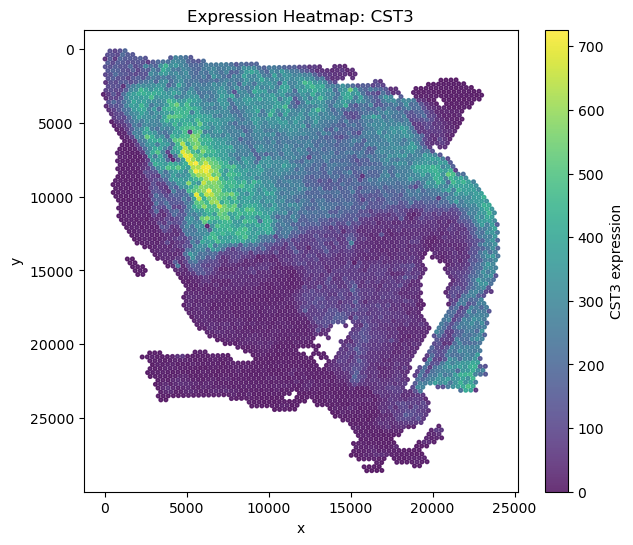

In [23]:
ranked_df = rank_genes_using_scanpy(sdata, RANKED_GENE_LIST_PATH)
plot_top_variable_gene(sdata, ranked_df, rank=4, output_path=f"{GENE_PLOTS_DIR}/top_{TOP_VARIABLE_GENE_RANK}.png")


## 🔗 **Joint Expression Analysis & Module Score Visualization**

This section performs a combined expression analysis for a set of candidate genes, providing insights into their collective activity across the tissue.

- The candidate genes are loaded from a CSV file (`candidate_genes.csv`), which contains a list of genes of interest.
- The function **`compute_joint_expression`** filters these genes to keep only those present in the dataset.
- It computes a **joint expression score** for each cell by averaging the expression values of the valid candidate genes, representing a module score.
- Spatial coordinates of each cell are extracted from the dataset.
- The joint expression scores, along with the spatial coordinates, are saved to a CSV file for further analysis.
- The function **`plot_joint_expression`** visualizes this combined score as a heatmap across the tissue.
- This approach helps identify spatial patterns of gene modules or pathways, offering biological insights beyond single-gene analysis.

The resulting heatmap plot is saved as `joint_expression_heatmap.png`.


In [24]:
# Load candidate gene list (one gene per line, no header)
candidate_genes = pd.read_csv(CANDIDATE_GENE_LIST_PATH, header=None)[0].tolist()
print(f"Loaded {len(candidate_genes)} genes.")

Loaded 32 genes.


In [25]:
def compute_joint_expression(sdata, gene_list):
    # Get the table (assumes single table)
    table = list(sdata.tables.values())[0]

    # Filter only genes present in the dataset
    valid_genes = [g for g in gene_list if g in table.var_names]
    if not valid_genes:
        raise ValueError("None of the genes are found in the dataset.")
    print(f"{len(valid_genes)} valid genes found in the dataset.")

    # Extract expression matrix and coordinates
    X = table[:, valid_genes].X
    if hasattr(X, "toarray"):
        X = X.toarray()

    joint_score = X.mean(axis=1)  # average expression per cell

    # Coordinates
    geometry = sdata.shapes[shape_layer_name]['geometry']
    x = geometry.x.values
    y = geometry.y.values

    return pd.DataFrame({"x": x, "y": y, "joint_score": joint_score})

In [26]:
joint_df = compute_joint_expression(sdata, candidate_genes)
joint_df.to_csv(JOINT_EXPR_CSV, index=False)
print("Saved joint scores with coordinates to joint_expression_scores.csv")

32 valid genes found in the dataset.
Saved joint scores with coordinates to joint_expression_scores.csv


In [27]:
def plot_joint_expression(joint_df, title="Joint Expression Heatmap", output_path=None):
    plt.figure(figsize=(7, 6))
    scatter = plt.scatter(joint_df["x"], joint_df["y"],
                          c=joint_df["joint_score"], cmap='plasma', s=SCATTER_POINT_SIZE, alpha=SCATTER_ALPHA)
    plt.colorbar(scatter, label="Joint Expression Score")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

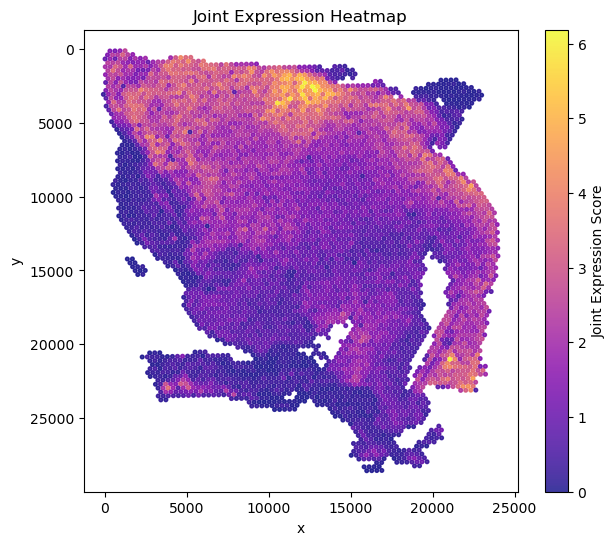

In [28]:
plot_joint_expression(joint_df, output_path=JOINT_EXPR_PLOT_PATH)